In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report, multilabel_confusion_matrix, make_scorer, f1_score
import time


In [2]:
if not (os.path.isfile("df_features_bow_sampled.parquet") and os.path.isfile("df_features_tfidf_sampled.parquet")):
    raise Exception("You should run the section 1 before")
df_features_bow_sampled = pd.read_parquet("df_features_bow_sampled.parquet")
df_features_tfidf_sampled = pd.read_parquet("df_features_tfidf_sampled.parquet")

<br>
<left><b><font size=4>Section 2 – Supervised Learning – Classification<b><left>

**2.1 Perform a split to segment the dataset into training and test dataset. If you want to standardize your dataset, fit the scaler on training set and transforming both training and test. Notice that the sklearn implementation of tf-idf already performs the standardization.**

In [3]:
%run "train_test_split_sampled.ipynb" 
X = df_features_tfidf_sampled.drop(columns=["Set_Fingerprint"])
y = df_features_tfidf_sampled["Set_Fingerprint"]

X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=0.7, random_state=42)

In [4]:
print(f"The size of trainning set is: {len(X_train)}")
print(f"The size of trainning set is: {len(X_test)}")

The size of trainning set is: 4097
The size of trainning set is: 1756


In [5]:
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.transform(y_test)

**2.2 Choose at least 2 ML methods, and perform the model training, with default parameter
configuration, evaluating the performance on both training and test set. Output the confusion
matrix and classification report. Do you observe overfitting or under-fitting? Which model
generates the best performance?**

<br><left><b><font size=4> Random Forest (RF)<b><left>

In [6]:
rf = RandomForestClassifier(random_state=42) 

st = time.time()
rf.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(f"Time to train the model: {elapsed_time:.2f} seconds")

Time to train the model: 0.89 seconds


In [7]:
y_train_predictions_rf = rf.predict(X_train)
y_test_predictions_rf = rf.predict(X_test)

In [8]:
# Evaluate the model's performance on the train data
accuracy = rf.score(X_train, y_train_mlb)
print(f"Accuracy of the 'Random Forest' model for the training set: {accuracy:.2f}")

# Evaluate the model's performance on the test data
accuracy = rf.score(X_test, y_test_mlb)
print(f"Accuracy of the 'Random Forest' model for test set: {accuracy:.2f}")

Accuracy of the 'Random Forest' model for the training set: 0.98
Accuracy of the 'Random Forest' model for test set: 0.98


<br>
<left><b><font size=3 >Classification Report<b><left>

##### Training Set

In [9]:
report_training = classification_report(y_train_mlb, y_train_predictions_rf, target_names=mlb.classes_, output_dict=True, zero_division=1)
df_report_training = pd.DataFrame(report_training).transpose()
df_report_training

,precision,recall,f1-score,support
Defense Evasion,0.990937,0.979104,0.984985,335.0
Discovery,1.000000,1.000000,1.000000,4070.0
Execution,1.000000,0.988408,0.994170,1639.0
Harmless,0.944444,0.354167,0.515152,48.0
Impact,1.000000,0.888889,0.941176,9.0
Other,1.000000,0.916667,0.956522,12.0
Persistence,0.999191,0.999460,0.999325,3705.0
micro avg,0.999283,0.993787,0.996527,9818.0
macro avg,0.990653,0.875242,0.913047,9818.0
weighted avg,0.999114,0.993787,0.995782,9818.0


##### Validation Set (Test set)

In [10]:
report_test = classification_report(y_test_mlb, y_test_predictions_rf, target_names=mlb.classes_, output_dict=True, zero_division=1)
df_report_test = pd.DataFrame(report_test).transpose()
df_report_test

,precision,recall,f1-score,support
Defense Evasion,0.971831,0.965035,0.968421,143.0
Discovery,0.998852,0.997135,0.997993,1745.0
Execution,0.992857,0.991441,0.992148,701.0
Harmless,1.000000,0.095238,0.173913,21.0
Impact,0.500000,0.200000,0.285714,5.0
Other,1.000000,0.600000,0.750000,5.0
Persistence,0.999369,0.999369,0.999369,1586.0
micro avg,0.996888,0.990014,0.993439,4206.0
macro avg,0.923273,0.692603,0.738223,4206.0
weighted avg,0.996543,0.990014,0.991276,4206.0


<br>
<left><b><font size=3> Confusion Matrix <b><left>

##### Training Set

In [11]:
confusion_rf_train = multilabel_confusion_matrix(y_train_mlb, y_train_predictions_rf)

for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for '{label}':")
    print(confusion_rf_train[i], "\n")

Confusion Matrix for 'Defense Evasion':
[[3759    3]
 [   7  328]] 

Confusion Matrix for 'Discovery':
[[  27    0]
 [   0 4070]] 

Confusion Matrix for 'Execution':
[[2458    0]
 [  19 1620]] 

Confusion Matrix for 'Harmless':
[[4048    1]
 [  31   17]] 

Confusion Matrix for 'Impact':
[[4088    0]
 [   1    8]] 

Confusion Matrix for 'Other':
[[4085    0]
 [   1   11]] 

Confusion Matrix for 'Persistence':
[[ 389    3]
 [   2 3703]] 



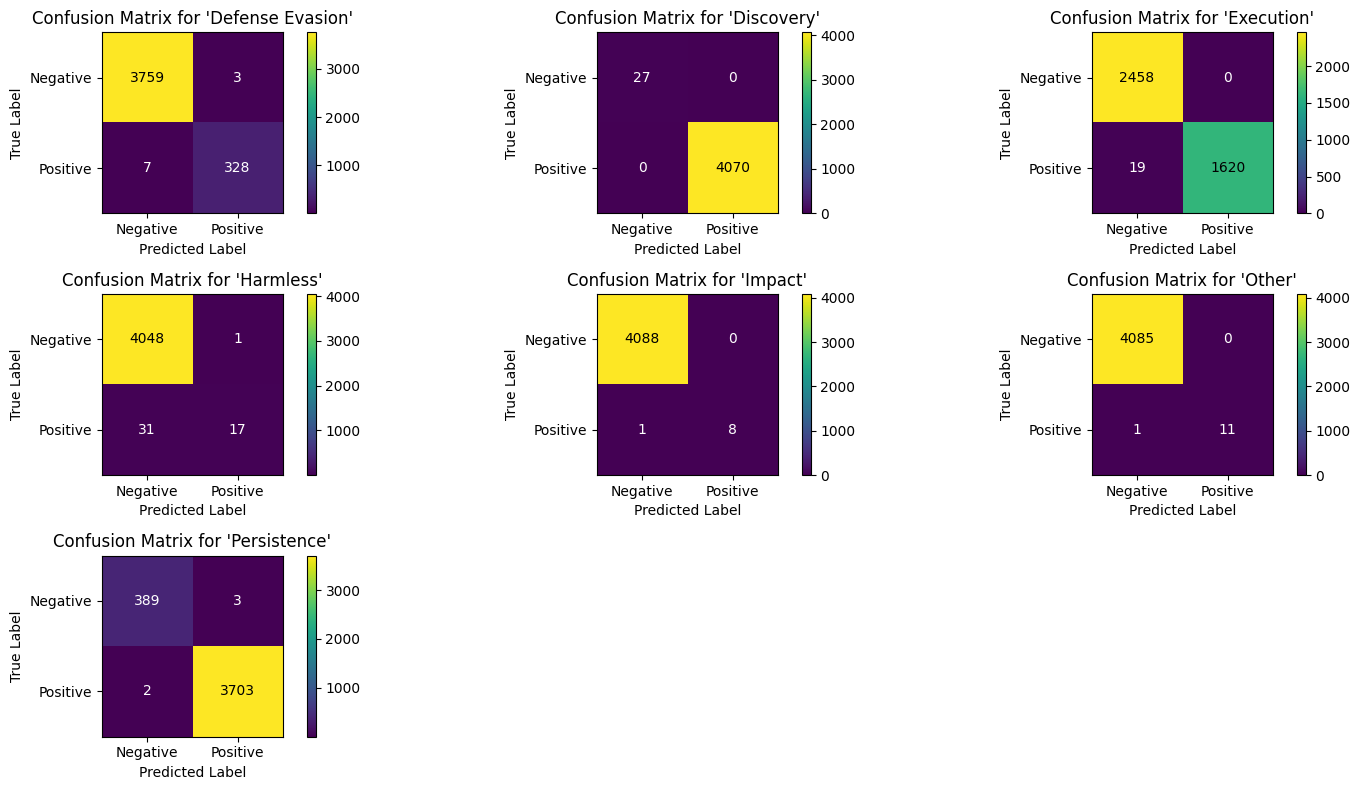

In [12]:
plt.figure(figsize=(15, 8))
for i, label in enumerate(mlb.classes_):
    plt.subplot(3, 3, i + 1)
    plt.title(f"Confusion Matrix for '{label}'")
    matrix = confusion_rf_train[i]
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    
    # Adding the numbers to the cells
    for (j, k), value in np.ndenumerate(matrix):
        plt.text(k, j, f'{value}', ha='center', va='center', color='white' if matrix[j, k] < matrix.max() / 2 else 'black')
    
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

plt.tight_layout()
plt.show()

##### Validation Set

In [13]:
confusion_rf_test = multilabel_confusion_matrix(y_test_mlb, y_test_predictions_rf)

for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for '{label}':")
    print(confusion_rf_test[i], "\n")   

Confusion Matrix for 'Defense Evasion':
[[1609    4]
 [   5  138]] 

Confusion Matrix for 'Discovery':
[[   9    2]
 [   5 1740]] 

Confusion Matrix for 'Execution':
[[1050    5]
 [   6  695]] 

Confusion Matrix for 'Harmless':
[[1735    0]
 [  19    2]] 

Confusion Matrix for 'Impact':
[[1750    1]
 [   4    1]] 

Confusion Matrix for 'Other':
[[1751    0]
 [   2    3]] 

Confusion Matrix for 'Persistence':
[[ 169    1]
 [   1 1585]] 



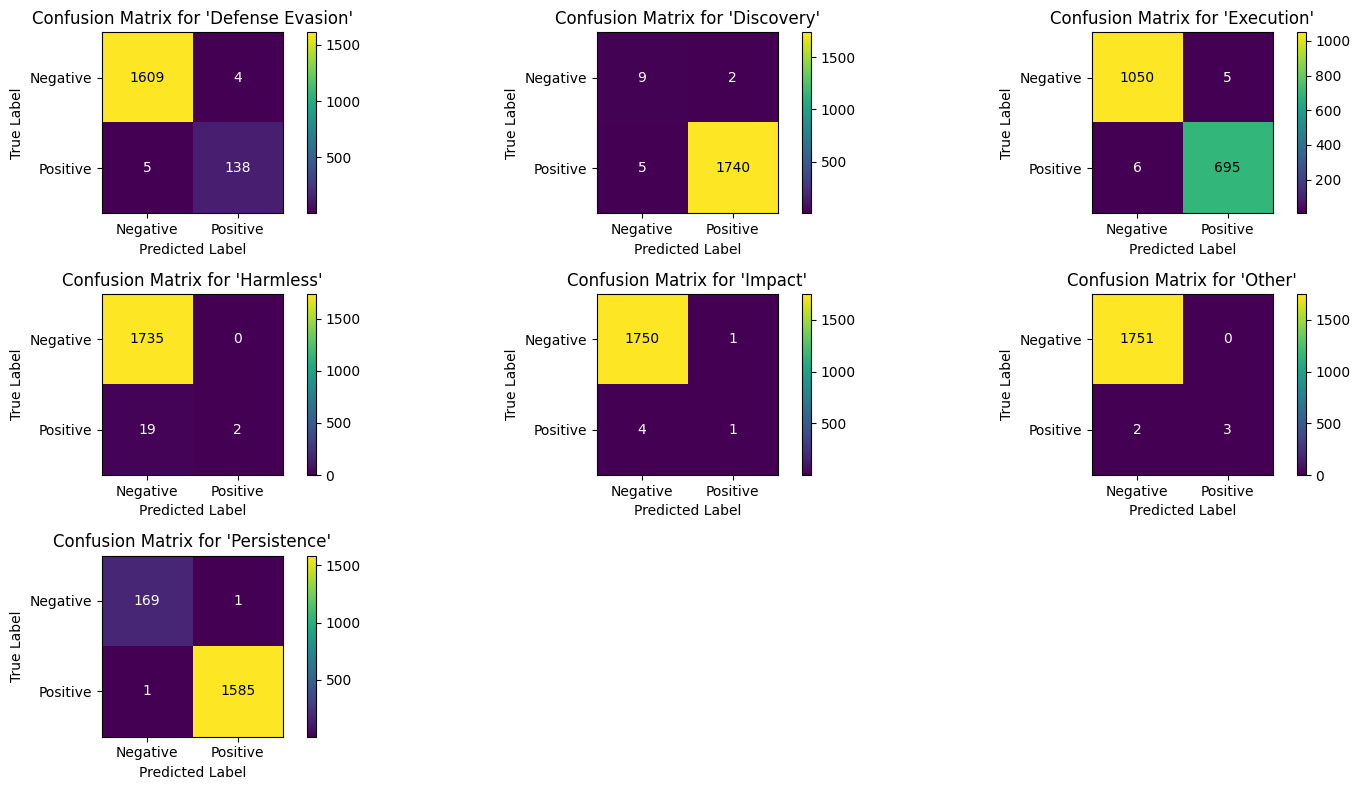

In [14]:
plt.figure(figsize=(15, 8))
for i, label in enumerate(mlb.classes_):
    plt.subplot(3, 3, i + 1)
    plt.title(f"Confusion Matrix for '{label}'")
    matrix = confusion_rf_test[i]
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    
    # Adding the numbers to the cells
    for (j, k), value in np.ndenumerate(matrix):
        plt.text(k, j, f'{value}', ha='center', va='center', color='white' if matrix[j, k] < matrix.max() / 2 else 'black')
    
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

plt.tight_layout()
plt.show()

<br>
<left><b><font size=4>K-Nearest Neighbors (KNN)<b><left>

In [15]:
knn = KNeighborsClassifier()

st = time.time()
knn.fit(X_train, y_train_mlb)
et = time.time()

elapsed_time = et - st
print(f"Time to train the model: {elapsed_time} seconds")

Time to train the model: 0.0 seconds


In [16]:
y_train_predictions_knn = knn.predict(X_train) 
y_test_predictions_knn = knn.predict(X_test)

In [17]:
# Evaluate the model's performance on the trining data
accuracy = knn.score(X_train, y_train_mlb)
print(f"Accuracy of the k-NN model for the training set: {accuracy:.2f}")

# Evaluate the model's performance on the test data
accuracy = knn.score(X_test, y_test_mlb)
print(f"Accuracy of the k-NN model for the test set: {accuracy:.2f}")

Accuracy of the k-NN model for the training set: 0.98
Accuracy of the k-NN model for the test set: 0.98


<br>
<left><b><font size=3 >Classification Report<b><left>

##### Training Set

In [18]:
# Classification Report for training set
report_train_knn = classification_report(y_train_mlb, y_train_predictions_knn, target_names=mlb.classes_, output_dict=True, zero_division=1)
df_report_train = pd.DataFrame(report_train_knn).transpose()
print("Classification Report for Training set:")
df_report_train

Classification Report for Training set:


,precision,recall,f1-score,support
Defense Evasion,0.964179,0.964179,0.964179,335.0
Discovery,0.997547,0.999263,0.998404,4070.0
Execution,0.995071,0.985357,0.990190,1639.0
Harmless,0.800000,0.083333,0.150943,48.0
Impact,1.000000,0.555556,0.714286,9.0
Other,1.000000,0.750000,0.857143,12.0
Persistence,0.998382,0.999190,0.998786,3705.0
micro avg,0.996210,0.990528,0.993361,9818.0
macro avg,0.965026,0.762411,0.810562,9818.0
weighted avg,0.995350,0.990528,0.991433,9818.0


##### Validation Set

In [19]:
# Classification Report for test set
report_test_knn = classification_report(y_test_mlb, y_test_predictions_knn, target_names=mlb.classes_, output_dict=True, zero_division=1)
df_report_test_knn = pd.DataFrame(report_test_knn).transpose()
print("Classification Report for Test set:")
df_report_test_knn

Classification Report for Test set:


,precision,recall,f1-score,support
Defense Evasion,0.945205,0.965035,0.955017,143.0
Discovery,0.996568,0.998281,0.997423,1745.0
Execution,0.991392,0.985735,0.988555,701.0
Harmless,1.000000,0.047619,0.090909,21.0
Impact,0.500000,0.200000,0.285714,5.0
Other,1.000000,0.400000,0.571429,5.0
Persistence,0.996226,0.998739,0.997481,1586.0
micro avg,0.993550,0.988825,0.991182,4206.0
macro avg,0.918484,0.656487,0.698076,4206.0
weighted avg,0.993261,0.988825,0.988647,4206.0


<br>
<left><b><font size=3> Confusion Matrix <b><left>

In [20]:
# Evaluate with a confusion matrix and classification report
confusion_knn_train = multilabel_confusion_matrix(y_train_mlb, y_train_predictions_knn)
for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for {label}:")
    print(confusion_knn_train[i], "\n")

Confusion Matrix for Defense Evasion:
[[3750   12]
 [  12  323]] 

Confusion Matrix for Discovery:
[[  17   10]
 [   3 4067]] 

Confusion Matrix for Execution:
[[2450    8]
 [  24 1615]] 

Confusion Matrix for Harmless:
[[4048    1]
 [  44    4]] 

Confusion Matrix for Impact:
[[4088    0]
 [   4    5]] 

Confusion Matrix for Other:
[[4085    0]
 [   3    9]] 

Confusion Matrix for Persistence:
[[ 386    6]
 [   3 3702]] 



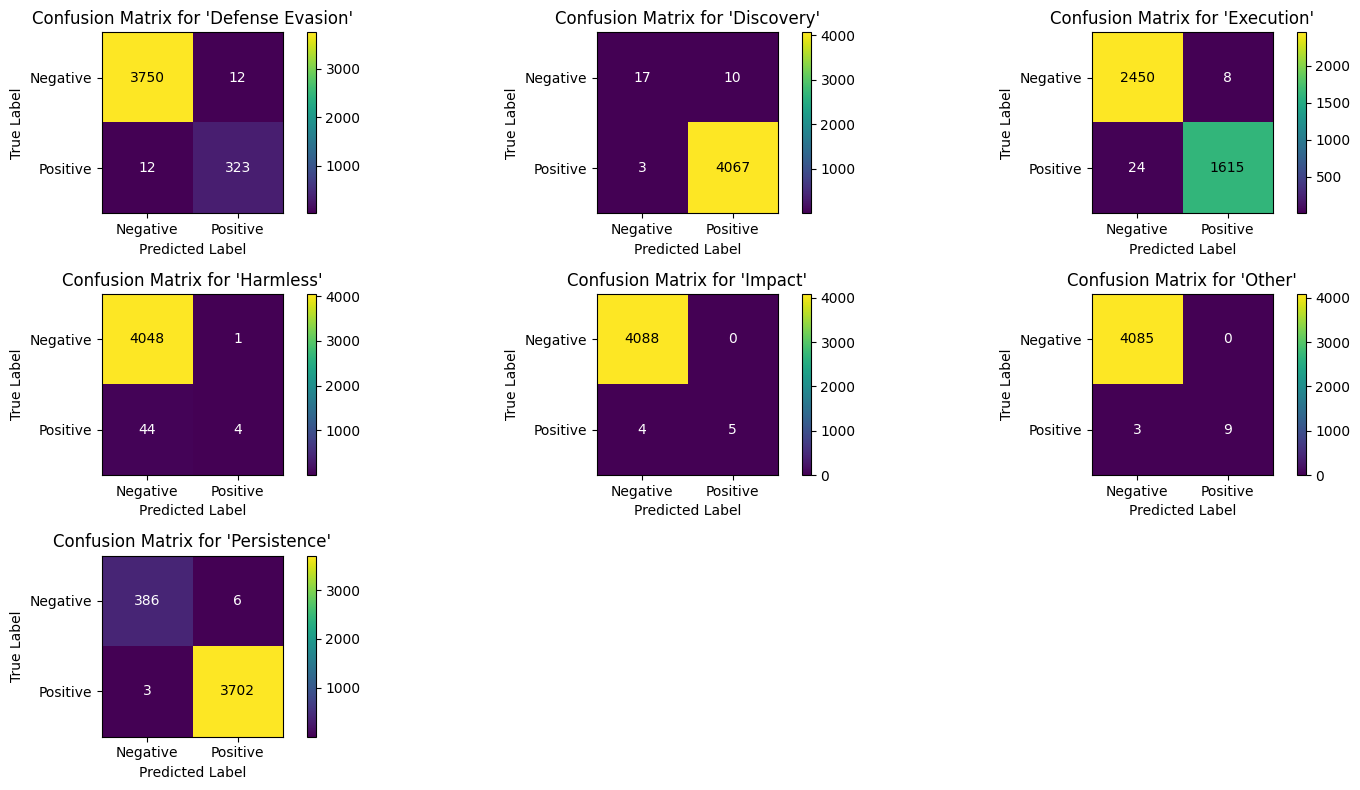

In [21]:
plt.figure(figsize=(15, 8))
for i, label in enumerate(mlb.classes_):
    plt.subplot(3, 3, i + 1)
    plt.title(f"Confusion Matrix for '{label}'")
    matrix = confusion_knn_train[i]
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    
    # Adding the numbers to the cells
    for (j, k), value in np.ndenumerate(matrix):
        plt.text(k, j, f'{value}', ha='center', va='center', color='white' if matrix[j, k] < matrix.max() / 2 else 'black')
    
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

plt.tight_layout()
plt.show()

In [22]:
# Evaluate with a confusion matrix and classification report
confusion_knn_test = multilabel_confusion_matrix(y_test_mlb, y_test_predictions_knn)
for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for {label}:")
    print(confusion_knn_test[i], "\n")

Confusion Matrix for Defense Evasion:
[[1605    8]
 [   5  138]] 

Confusion Matrix for Discovery:
[[   5    6]
 [   3 1742]] 

Confusion Matrix for Execution:
[[1049    6]
 [  10  691]] 

Confusion Matrix for Harmless:
[[1735    0]
 [  20    1]] 

Confusion Matrix for Impact:
[[1750    1]
 [   4    1]] 

Confusion Matrix for Other:
[[1751    0]
 [   3    2]] 

Confusion Matrix for Persistence:
[[ 164    6]
 [   2 1584]] 



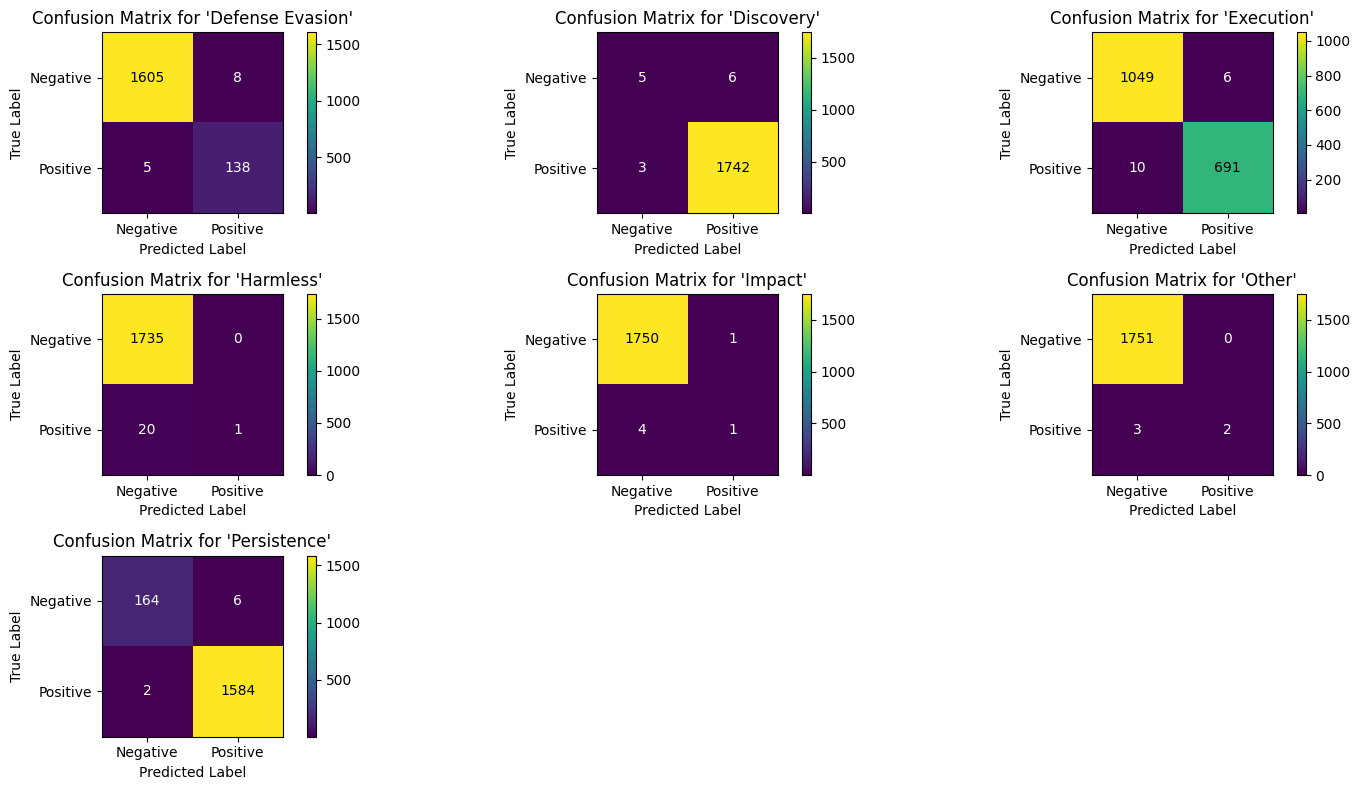

In [23]:
plt.figure(figsize=(15, 8))
for i, label in enumerate(mlb.classes_):
    plt.subplot(3, 3, i + 1)
    plt.title(f"Confusion Matrix for '{label}'")
    matrix = confusion_knn_test[i]
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    
    # Adding the numbers to the cells
    for (j, k), value in np.ndenumerate(matrix):
        plt.text(k, j, f'{value}', ha='center', va='center', color='white' if matrix[j, k] < matrix.max() / 2 else 'black')
    
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

plt.tight_layout()
plt.show()

**2.3 Tune the hyper-parameters of the models through cross-validation. How do performance vary?**

#### Grid Search Technique

#### Random Forest

In [24]:
params = {'n_estimators': [10, 30, 70, 100, 120, 150], 'max_depth': [10, 50, 70, 100, None]} 

gs_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid = params, scoring = make_scorer(f1_score, average='weighted', zero_division=1)
, cv = 7, verbose = 1) 

st = time.time()
gs_rf.fit(X_train, y_train_mlb)
et = time.time()


elapsed_time = et - st
print(f"Time to train the model: {elapsed_time} seconds")

Fitting 7 folds for each of 30 candidates, totalling 210 fits
Time to train the model: 109.82036018371582 seconds


In [25]:
best_params_rf = gs_rf.best_params_
print(f"The best combination of parameters the Grid Search has found is: {best_params_rf}")
print(f"Best F1-Score: {gs_rf.best_score_:.2f}")

The best combination of parameters the Grid Search has found is: {'max_depth': 10, 'n_estimators': 10}
Best F1-Score: 0.99


In [26]:
results_rf = pd.DataFrame(gs_rf.cv_results_)
results_rf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0.087801,0.042753,0.011271,0.007133,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.997469,0.991989,0.987749,0.990532,0.998199,0.994816,0.989157,0.992844,0.003772,1
1,0.187995,0.008440,0.017859,0.005463,10,30,"{'max_depth': 10, 'n_estimators': 30}",0.997469,0.992704,0.988914,0.990060,0.992459,0.995181,0.988776,0.992223,0.003025,6
2,0.426346,0.024653,0.040172,0.007729,10,70,"{'max_depth': 10, 'n_estimators': 70}",0.997829,0.992704,0.988914,0.990061,0.992819,0.994100,0.988776,0.992172,0.003000,9
3,0.616077,0.035299,0.050071,0.005574,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.997469,0.992704,0.988914,0.989703,0.992819,0.994460,0.988776,0.992121,0.002981,14
4,0.666547,0.025149,0.056843,0.007413,10,120,"{'max_depth': 10, 'n_estimators': 120}",0.997469,0.992704,0.988914,0.990061,0.992819,0.994460,0.988776,0.992172,0.002942,8
5,0.829207,0.028787,0.070740,0.006020,10,150,"{'max_depth': 10, 'n_estimators': 150}",0.997469,0.992704,0.988914,0.990061,0.992819,0.994464,0.988776,0.992173,0.002943,7
6,0.063224,0.009649,0.009098,0.007629,50,10,"{'max_depth': 50, 'n_estimators': 10}",0.997469,0.991989,0.987385,0.989886,0.998197,0.993974,0.989128,0.992576,0.003853,2
7,0.170333,0.010771,0.020134,0.011823,50,30,"{'max_depth': 50, 'n_estimators': 30}",0.997469,0.992906,0.988099,0.989940,0.992459,0.994946,0.989129,0.992135,0.003098,10
8,0.416026,0.043244,0.034936,0.007104,50,70,"{'max_depth': 50, 'n_estimators': 70}",0.997469,0.992704,0.988099,0.989449,0.992462,0.994946,0.988776,0.991986,0.003194,23
9,0.562360,0.015269,0.049357,0.003549,50,100,"{'max_depth': 50, 'n_estimators': 100}",0.997469,0.992704,0.988099,0.989940,0.992102,0.994946,0.988776,0.992005,0.003139,19


In [27]:
# We create a pivot table 
scores_rf = results_rf.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
scores_rf

param_n_estimators,10,30,70,100,120,150
param_max_depth,,,,,,
NaN,0.992576,0.992135,0.991986,0.992005,0.991953,0.992056
10.0,0.992844,0.992223,0.992172,0.992121,0.992172,0.992173
50.0,0.992576,0.992135,0.991986,0.992005,0.991953,0.992056
70.0,0.992576,0.992135,0.991986,0.992005,0.991953,0.992056
100.0,0.992576,0.992135,0.991986,0.992005,0.991953,0.992056


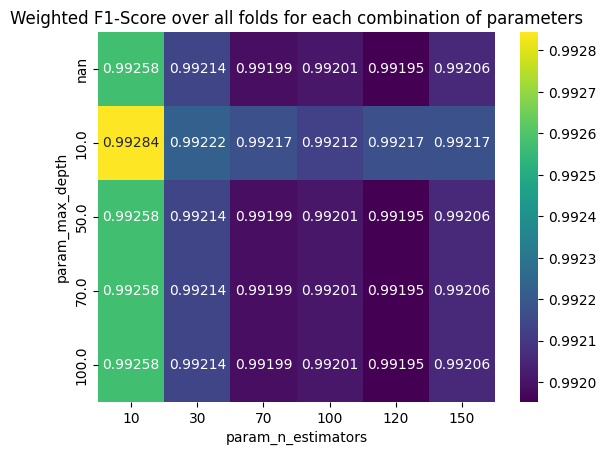

In [28]:
sns.heatmap(scores_rf, annot=True, cmap='viridis', fmt='.5g')
plt.xlabel('param_n_estimators')
plt.ylabel('param_max_depth')
plt.title('Weighted F1-Score over all folds for each combination of parameters')
plt.show()

#### K-Nearest Neighbor

In [29]:
params = {
    'n_neighbors': [2, 3, 5],
    'leaf_size': [10, 30, 50, 80],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

grid_search_knn = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = params, scoring = make_scorer(f1_score, average='weighted', zero_division=1), cv = 7, verbose=1)

st = time.time()
grid_search_knn.fit(X_train, y_train_mlb)
et = time.time()

elapsed_time = et - st

print(f"Time to train the model: {elapsed_time} seconds")

Fitting 7 folds for each of 96 candidates, totalling 672 fits
Time to train the model: 128.15572953224182 seconds


In [30]:
best_params_knn = grid_search_knn.best_params_
print(f"\nThe best combination of parameters the Grid Search has found is: {best_params_knn}")
print("Best F1-Score: {:.2f}".format(grid_search_knn.best_score_))


The best combination of parameters the Grid Search has found is: {'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best F1-Score: 0.99


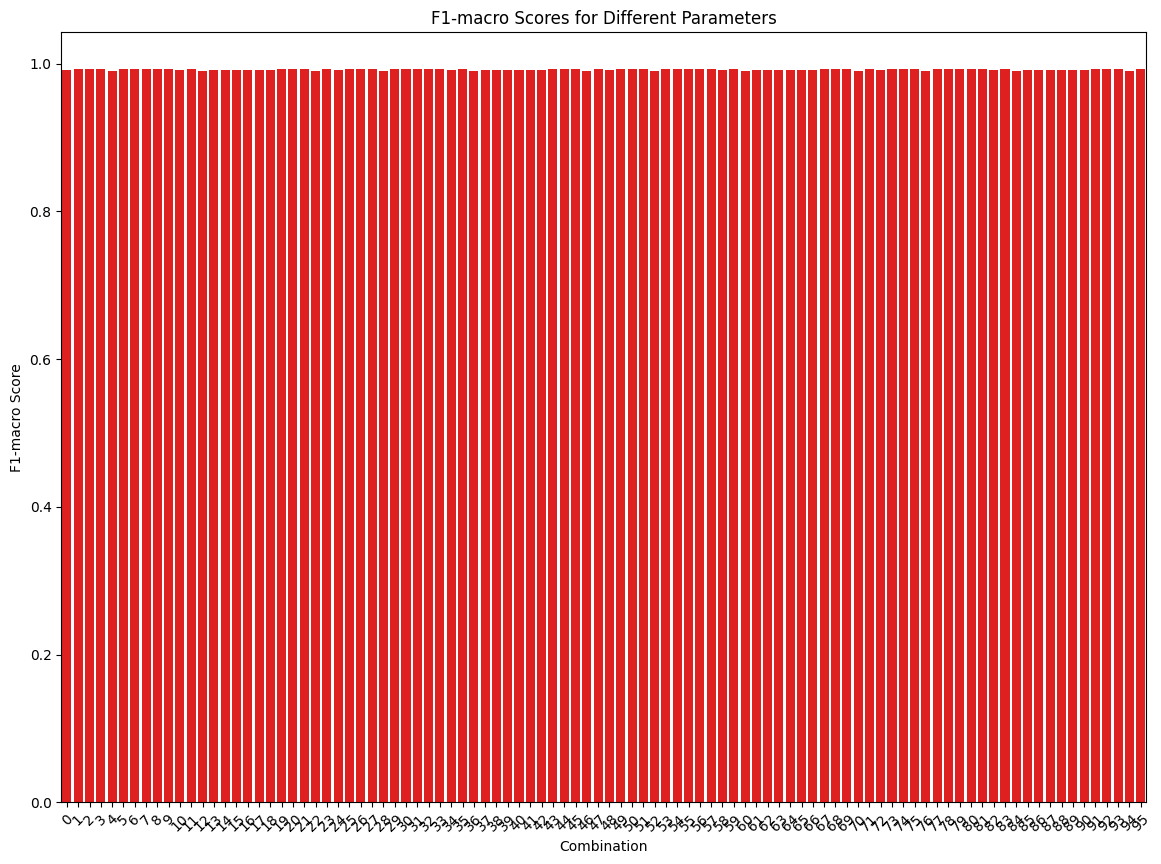

In [31]:
# Let's print the f1 macro reached for each combination
y = grid_search_knn.cv_results_["mean_test_score"].tolist()
x = [i for i in range (1, len(y)+1)]
mean_test_score_df = pd.DataFrame()
mean_test_score_df["f1_macro"] = y

sns.barplot(x = mean_test_score_df.index, y = "f1_macro", data = mean_test_score_df, color='r')

# Set the figure size
plt.gcf().set_size_inches(14, 10)
# Add a title and labels to the plot
plt.title('F1-macro Scores for Different Parameters')
plt.xlabel('Combination')
plt.ylabel('F1-macro Score')

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45) 

# Display the plot
plt.show()

In [32]:
results_knn = pd.DataFrame(grid_search_knn.cv_results_)
print(results_knn)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.005005      0.006846         0.322539        0.080277   
1        0.006697      0.007733         0.020089        0.007058   
2        0.011160      0.007059         0.279018        0.009983   
3        0.002231      0.005466         0.024558        0.007735   
4        0.002232      0.005468         0.299106        0.034866   
..            ...           ...              ...             ...   
91       0.003744      0.007662         0.024771        0.008862   
92       0.004894      0.007304         0.266624        0.012508   
93       0.000572      0.001400         0.025610        0.007266   
94       0.007188      0.008303         0.266922        0.000282   
95       0.004733      0.007484         0.023716        0.008063   

   param_leaf_size param_metric param_n_neighbors param_weights  \
0               10    euclidean                 2       uniform   
1               10    euclidean                 2

In [33]:
# Extract relevant columns
pivot_columns = ['param_n_neighbors', 'param_leaf_size', 'param_weights', 'param_metric', 'mean_test_score']
pivot_data = results_knn[pivot_columns]

# Create a pivot table
pivot_table = pivot_data.pivot_table(index=['param_n_neighbors', 
                                            'param_leaf_size', 
                                            'param_weights', 
                                            'param_metric'], 
                                     values='mean_test_score')

print("\nBest parameters and their corresponding mean test scores:")
pivot_table


Best parameters and their corresponding mean test scores:


mean_test_score
param_n_neighbors param_leaf_size param_weights param_metric                 
2                 10              distance      chebyshev            0.991553
                                                euclidean            0.992612
                                                manhattan            0.992444
                                                minkowski            0.992612
                                  uniform       chebyshev            0.989958
...                                                                       ...
5                 80              distance      minkowski            0.991922
                                  uniform       chebyshev            0.990726
                                                euclidean            0.990429
                                                manhattan            0.990983
                                                minkowski            0.990429

[96 rows x 1 columns]

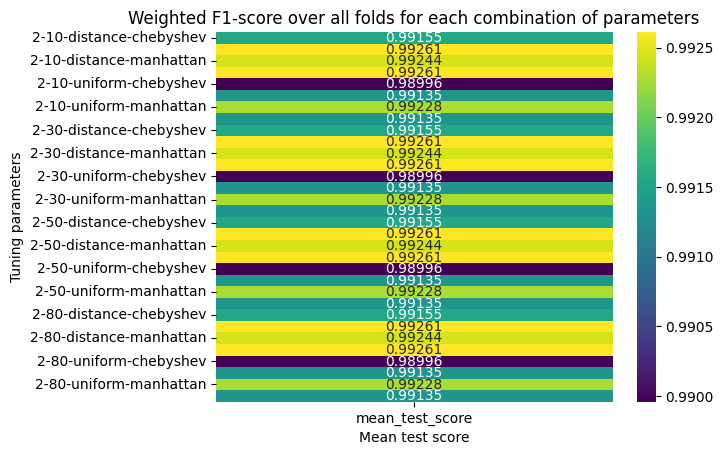

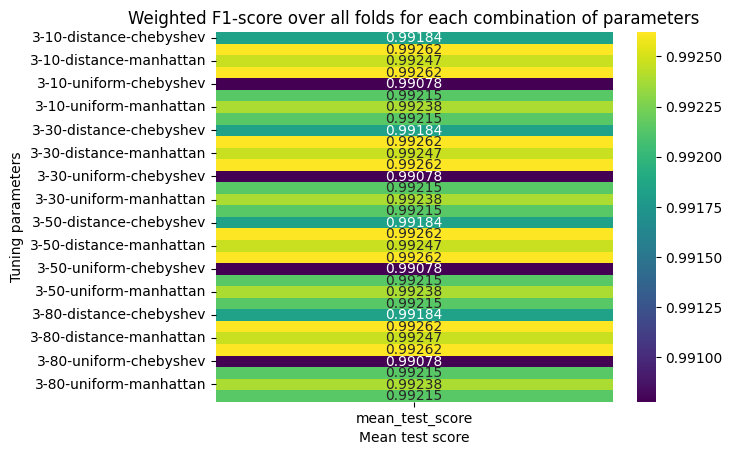

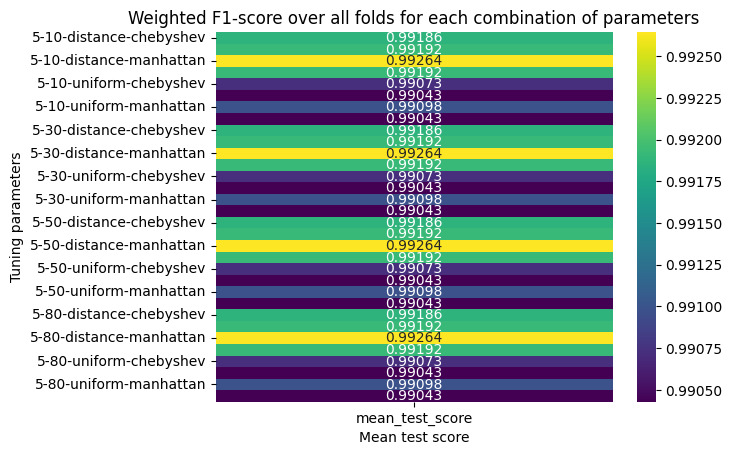

In [34]:
# Filter pivot_table to select rows where param_n_neighbors == 2
filtered_table_1 = pivot_table[pivot_table.index.get_level_values('param_n_neighbors') == 2]
filtered_table_2 = pivot_table[pivot_table.index.get_level_values('param_n_neighbors') == 3]
filtered_table_3 = pivot_table[pivot_table.index.get_level_values('param_n_neighbors') == 5]

sns.heatmap(filtered_table_1, annot=True, cmap='viridis', fmt='.5g')
plt.xlabel('Mean test score')
plt.ylabel('Tuning parameters')
plt.title('Weighted F1-score over all folds for each combination of parameters')
plt.show()

sns.heatmap(filtered_table_2, annot=True, cmap='viridis', fmt='.5g')
plt.xlabel('Mean test score')
plt.ylabel('Tuning parameters')
plt.title('Weighted F1-score over all folds for each combination of parameters')
plt.show()

sns.heatmap(filtered_table_3, annot=True, cmap='viridis', fmt='.5g')
plt.xlabel('Mean test score')
plt.ylabel('Tuning parameters')
plt.title('Weighted F1-score over all folds for each combination of parameters')
plt.show()

**2.4. Comments on the results for each on the intents.**

#### Evaluation of Random Forest with tuned parameters

In [35]:
model_rf_tunned = RandomForestClassifier(n_estimators = best_params_rf["n_estimators"], max_depth = best_params_rf["max_depth"], random_state=42)

st = time.time()
model_rf_tunned.fit(X_train, y_train_mlb)
et = time.time()


elapsed_time = et - st
print(f'Time to train the model:', elapsed_time,'seconds','\n')

y_test_pred_tune = model_rf_tunned.predict(X_test)


accuracy = model_rf_tunned.score(X_test, y_test_mlb)
f1_tuned = f1_score(y_test_mlb, y_test_pred_tune, average='weighted')

print(f"\nAccuracy of the 'Random Forest' model for test set: {accuracy:.2f}")
print(f"F1-score of the Random Forest model: {f1_tuned:.2f}",'\n')


report_test_tune = classification_report(y_test_mlb, y_test_pred_tune, target_names=mlb.classes_, 
                                         output_dict=True,
                                         zero_division=1)

df_report_test_tune = pd.DataFrame(report_test_tune).transpose()
print(f'         Classification Report Trainning Set', '\n')
print(df_report_test_tune)

Time to train the model: 0.08244872093200684 seconds 


Accuracy of the 'Random Forest' model for test set: 0.98
F1-score of the Random Forest model: 0.99 

         Classification Report Trainning Set 

                 precision    recall  f1-score  support
Defense Evasion   0.971831  0.965035  0.968421    143.0
Discovery         0.999425  0.996562  0.997991   1745.0
Execution         0.992857  0.991441  0.992148    701.0
Harmless          1.000000  0.095238  0.173913     21.0
Impact            1.000000  0.200000  0.333333      5.0
Other             1.000000  0.600000  0.750000      5.0
Persistence       0.999369  0.998739  0.999054   1586.0
micro avg         0.997364  0.989539  0.993436   4206.0
macro avg         0.994783  0.692431  0.744980   4206.0
weighted avg      0.997375  0.989539  0.991213   4206.0
samples avg       0.996185  0.989655  0.992723   4206.0


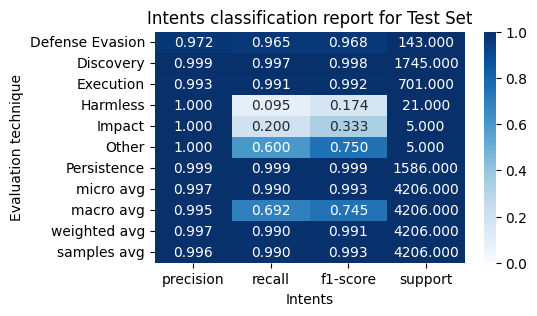

In [36]:
# Compute the heatmap of the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(df_report_test_tune.loc["Defense Evasion" : "samples avg"], cmap='Blues', annot=True, vmin=.0, vmax=1,fmt='.3f')
plt.xlabel('Intents')
plt.ylabel('Evaluation technique')
plt.title('Intents classification report for Test Set')
plt.show()

#### Evalutaing of K-Nearest Neighbors with tuned parameters

In [37]:
# Create the k-NN model
knn_tune = KNeighborsClassifier(leaf_size=best_params_knn["leaf_size"], n_neighbors=best_params_knn["n_neighbors"], metric= best_params_knn["metric"], weights=best_params_knn["weights"])

# Train the model on the training data
t = time.time()
knn_tune.fit(X_train, y_train_mlb)
et = time.time()

# get the execution time
elapsed_time = et - st
print(f"Time to train the model: {elapsed_time} seconds")

# Generate predictions on the test set
predictions_knn_tune = knn_tune.predict(X_test)

# Evaluate the model's performance on the test data
accuracy_knn_tune = knn_tune.score(X_test, y_test_mlb)
f1_tuned = f1_score(y_test_mlb, predictions_knn_tune, average='weighted')

print(f"\nAccuracy of the k-NN model: {accuracy_knn_tune:.2f}")
print(f"F1-score of the k-NN model: {f1_tuned:.2f}",'\n')

report_knn_tune = classification_report(y_test_mlb, predictions_knn_tune, target_names = mlb.classes_, output_dict=True,
                                       zero_division=1)

df_report_knn_tune = pd.DataFrame(report_knn_tune).transpose()
print("              Classification Report for KNN",'\n')
print(df_report_knn_tune)

Time to train the model: 0.7119722366333008 seconds

Accuracy of the k-NN model: 0.98
F1-score of the k-NN model: 0.99 

              Classification Report for KNN 

                 precision    recall  f1-score  support
Defense Evasion   0.958333  0.965035  0.961672    143.0
Discovery         0.999425  0.995989  0.997704   1745.0
Execution         0.995690  0.988588  0.992126    701.0
Harmless          0.500000  0.095238  0.160000     21.0
Impact            0.500000  0.200000  0.285714      5.0
Other             1.000000  0.600000  0.750000      5.0
Persistence       0.998739  0.998739  0.998739   1586.0
micro avg         0.996406  0.988825  0.992601   4206.0
macro avg         0.850312  0.691941  0.735136   4206.0
weighted avg      0.994060  0.988825  0.990616   4206.0
samples avg       0.994970  0.988136  0.992084   4206.0


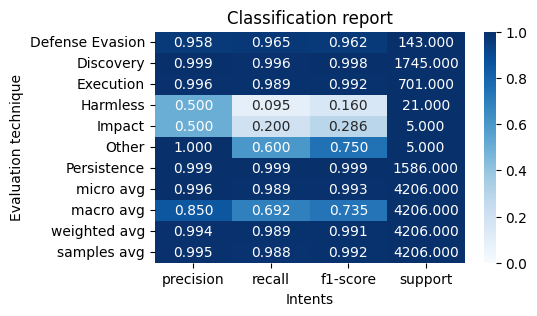

In [38]:
# Compute the heatmap of the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(df_report_knn_tune.loc["Defense Evasion" : "samples avg"], cmap='Blues', annot=True, vmin=.0, vmax=1,fmt='.3f')
plt.xlabel('Intents')
plt.ylabel('Evaluation technique')
plt.title('Classification report')
plt.show()